# Gerenal API quickstart
* https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/api_quickstart.html

In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.2
Running on ArviZ v0.11.2


## 1. Model creation
* PyMC3에서는 Model Class를 사용한다. 여기에 모든 랜덤변수의 참조가 들어가고, model 관련 logp계산과 gradients도 계산한다. with와 같이 사용한다.

In [4]:
with pm.Model() as model:
    # Model definition
    pass

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

In [5]:
model.basic_RVs # see above for reference Random Variables

[mu ~ Normal, obs ~ Normal]

In [6]:
model.free_RVs

[mu ~ Normal]

In [7]:
model.observed_RVs

[obs ~ Normal]

In [8]:
model.logp({"mu": 0})

array(-147.13654446)

In [9]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu: 0.1})

51.8 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.6 µs ± 410 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


* logp는 static하지 않다. 그래서 cache하는데 오래 걸리는데, 만약 logp=model.logp로 static하게 만들어 버리면 빨라진다.

## 2. Probability Distributions
* 모든 확률적 프로그램은 관찰된 랜덤변수, 관찰하지 않은 랜덤변수를 구성한다. 관찰된 RVs는 likelihood 분포로 정의되고, 관찰하지 않은 RVs는 선험분포로 정의된다. PyMC3에서는 main module에서 확률분포를 사용할 수 있다. 

In [10]:
help(pm.Normal) # example of probability distributions and documentation

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Normal(name, *args, **kwargs)
 |  
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, labe

In [11]:
print(dir(pm.distributions))
print(dir(pm.distributions.continuous))
print(dir(pm.distributions.discrete))
print(dir(pm.distributions.timeseries))
print(dir(pm.distributions.mixture))

['AR', 'AR1', 'AsymmetricLaplace', 'BART', 'Bernoulli', 'Beta', 'BetaBinomial', 'Binomial', 'Bound', 'Categorical', 'Cauchy', 'ChiSquared', 'Constant', 'ConstantDist', 'Continuous', 'DensityDist', 'Dirichlet', 'DirichletMultinomial', 'Discrete', 'DiscreteUniform', 'DiscreteWeibull', 'Distribution', 'ExGaussian', 'Exponential', 'Flat', 'GARCH11', 'Gamma', 'GaussianRandomWalk', 'Geometric', 'Gumbel', 'HalfCauchy', 'HalfFlat', 'HalfNormal', 'HalfStudentT', 'HyperGeometric', 'Interpolated', 'InverseGamma', 'KroneckerNormal', 'Kumaraswamy', 'LKJCholeskyCov', 'LKJCorr', 'Laplace', 'Logistic', 'LogitNormal', 'Lognormal', 'MatrixNormal', 'Mixture', 'MixtureSameFamily', 'Moyal', 'Multinomial', 'MvGaussianRandomWalk', 'MvNormal', 'MvStudentT', 'MvStudentTRandomWalk', 'NegativeBinomial', 'NoDistribution', 'Normal', 'NormalMixture', 'OrderedLogistic', 'OrderedProbit', 'Pareto', 'Poisson', 'Rice', 'Simulator', 'SkewNormal', 'StudentT', 'TensorType', 'Triangular', 'TruncatedNormal', 'Uniform', 'VonM

* 위 output에서 볼수 있듯, PyMC3의 probability distribution 구조는 다음과 같다.
* pymc3.distributions - continuous - discrete - timeseries - mixture

### Unobserved Random Variables
* 모든 관찰하지 않은 RV는 arg로 name(str)과 관련 parameter를 받는다. 

In [12]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

x.logp({"x": 0})

array(-0.91893853)

### Observed Random Variables
* 관찰되는 RV는 위의 관찰하지 않은 RV와 arg를 비슷하게 받지만, 추가적으로 observed라는 arg를 받아야 한다.
* observed에는 list, numpy.ndarray, theano, pandas dataframe를 줄 수 있다. 

In [13]:
with pm.Model():
    obs = pm.Normal("x", mu=0, sigma=1, observed=np.random.randn(100))

### Deterministic transforms
* PyMC3는 RV를 가지고 algebra를 할수있도록 지원한다.

In [14]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x ** 2
    sined = pm.math.sin(x)

* 자연스런게 대수 계산이 되긴 하지만, 저장이 자동적으로 되는 것은 아니다. 이것 변환된(대수 계산한) 변수들을 계속 쓰고 싶다면, pm.Deterministic을 사용해야 한다. 

In [15]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

### Automatic transforms of bounded RVs
* PyMC3는 bounded RV는 unbounded로 자동적으로 변환해준다. 

In [16]:
with pm.Model() as model:
    x = pm.Uniform("x", lower = 0, upper = 1)

model.free_RVs

[x_interval__ ~ TransformedDistribution]

* "x_interval__"은 x가 (-inf, +inf) 사이의 parameter 값을 받을 수 있도록 자동적 변환되었음을 말한다. upper, lower bound에 대해서 LogOdds 변환이 적용되었다. 이렇게 변환된 공간에서 sample이 더 수월하다. PyMC3는 물론 non-transformed, bounded parameter도 추적하며, 이것은 deterministics로 되어있다.

In [17]:
model.deterministics

[x ~ Uniform]

* PyMC3가 결과를 보여줄 때는 변환된 parameter는 숨김 처리한다. include_transformed=True라고 하면 볼 수 있다. 
* 반대로 transform자체를 끌 수도 있다. 

In [18]:
with pm.Model() as model:
    x = pm.Uniform("x", lower = 0, upper = 1, transform=None)

model.free_RVs

[x ~ Uniform]

* 또는 transform형태를 지정해줄수도 있다. 

In [19]:
import pymc3.distributions.transforms as tr

with pm.Model() as model:
    # default log transformation
    x1 = pm.Gamma("x1", alpha=1, beta=1)
    # log exp transform
    x2 = pm.Gamma("x2", alpha=1, beta=1, transform=tr.log_exp_m1)

print("The default transformation of x1 is: " + x1.transformation.name)
print("The user specified transformation of x2 is: " + x2.transformation.name)

The default transformation of x1 is: log
The user specified transformation of x2 is: log_exp_m1


### Transformed distributions and changes of variables
* PyMC3는 한 분포에서 다른 분포로 변환하는 것을 명시적으로 제공하지 않는다. 하지만, 변환 분포를 만들 수 있다. kwarg를 줘서. 다음 Normal distribution을 LogNormal로 변환하는 다음 예시를 보자.

$$ log(y) \sim Normal(\mu, \sigma) $$


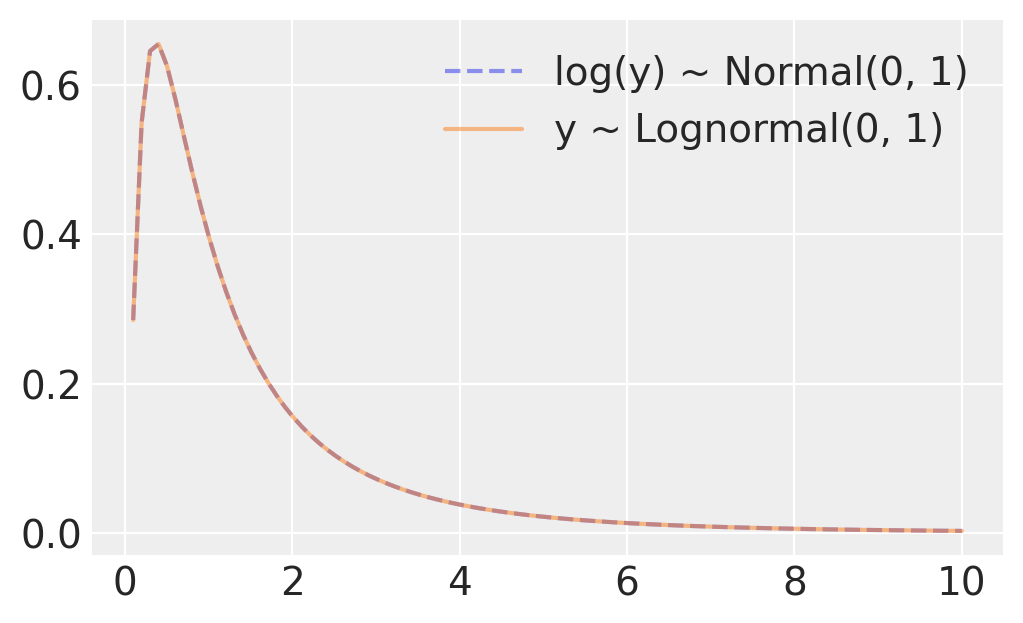

In [20]:
class Exp(tr.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)

with pm.Model() as model:
    x1 = pm.Normal("x1", 0.0, 1.0, transform=Exp())
    x2 = pm.Lognormal("x2", 0.0, 1.0)

lognorm1 = model.named_vars["x1_exp__"]
lognorm2 = model.named_vars["x2"]

_, ax = plt.subplots(1,1, figsize=(5,3))
x = np.linspace(0.0, 10.0, 100)

ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    "--",
    alpha = 0.5,
    label = "log(y) ~ Normal(0, 1)"
)
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha = 0.5,
    label = "y ~ Lognormal(0, 1)"
)
plt.legend()

In [21]:
Order = tr.Ordered()
Logodd = tr.LogOdds()
chain_train = tr.Chain([Logodd, Order])

with pm.Model() as m0:
    x = pm.Uniform("x", 0.0, 1.0, shape=2, transform=chain_train, testval=[0.1, 0.9])
    trace = pm.sample(5000, tune=1000, progressbar=True, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/tmp/ipykernel_1292190/1899122351.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


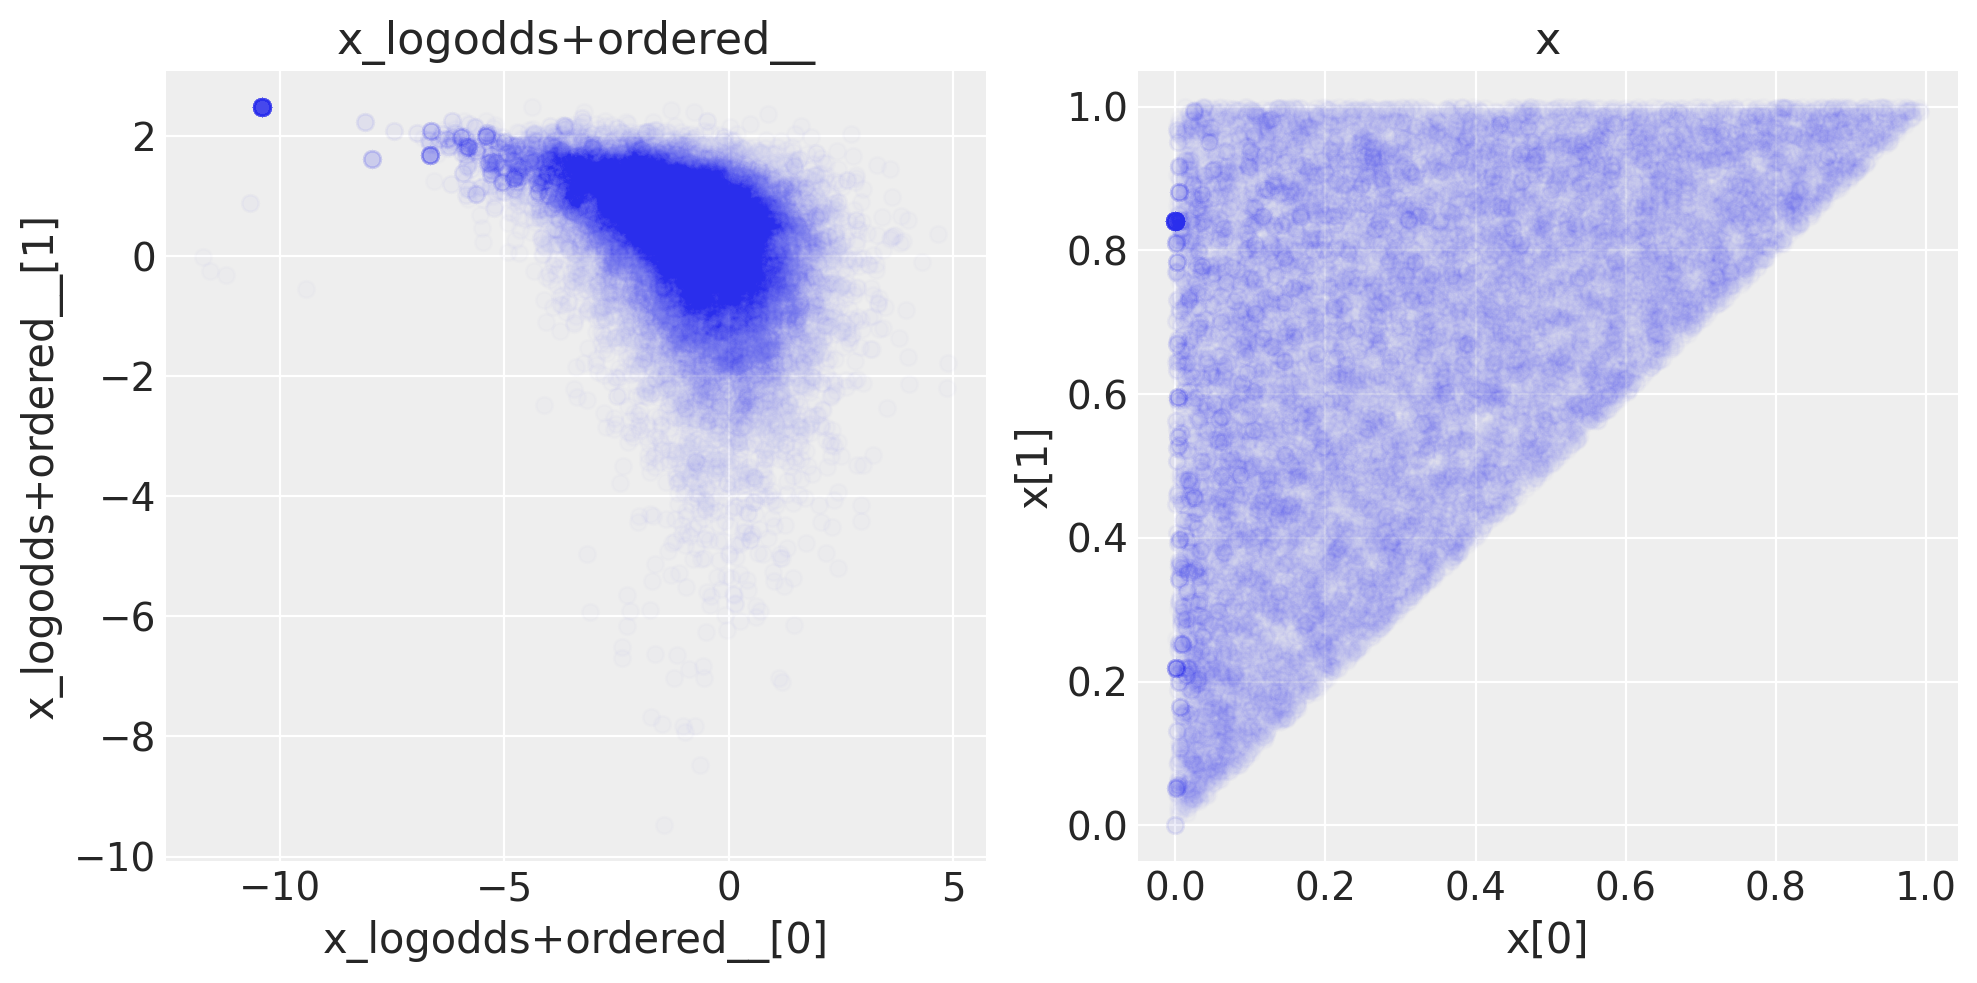

In [22]:
_, ax = plt.subplots(1, 2, figsize = (10, 5))
for ivar, varname in enumerate(trace.varnames):
    ax[ivar].scatter(trace[varname][:,0], trace[varname][:,1], alpha=0.01)
    ax[ivar].set_xlabel(varname + "[0]")
    ax[ivar].set_ylabel(varname + "[1]")
    ax[ivar].set_title(varname)
plt.tight_layout()

### Lists of RVs/higer-dimensional RVs
* 위에서 scalar RVs를 생성했는데, 많은 경우 우리는 multiple RVs가 필요하다. 이 때 shape이라는 kwarg를 사용하자. 

In [23]:
# Bad example, using for-loop, takes time.
with pm.Model():
    x = [pm.Normal(f"x_{i}", mu=0, sigma=1) for i in range(10)]

In [24]:
# Good example, using vectorization, takes much less time.
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1, shape=10)

In [25]:
# We can index and apply linear algebra to each RVs in vector.
with model:
    y = x[0] * x[1]  # full indexing is supported
    x.dot(x.T)  # Linear algebra is supported

### Initialization with test_values
* PyMC3는 초기화를 자동으로 해주지만, 정의해줄수도 있다. 이때는 testval이라는 kwarg를 사용한다. 

In [26]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1, shape=5)
x.tag.test_value

array([0., 0., 0., 0., 0.])

* 초기 test값이 0인 것을 볼 수 있다. 

In [27]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1, shape=5, testval=np.random.randn(5))
x.tag.test_value

array([ 1.22022099,  0.34502213,  0.12561427, -0.73643125, -0.68958496])

* 모델 초기화할 때 유용하니 알아두자.

## 3. Inference

* 이제 사후 분포를 추정하는 것을 해보자. sampling과 variational inference 크게 두가지 방법을 PyMC3로 할 수 있다. 

### 3.1 Sampling
* MCMC 샘플링은 pm.sample()로 한다.
* PyMC3 >=3.9 부터는 return_infererencedata라는 kwarg가 있고, 이걸 True로 두면 arviz.InferenceData 객체가 반환된다. 이건 MultiTrace보다 낫다.
* arviz는 베이즈 추론을 위한 그래프 시각화 툴이다. 자세한 것은 [Arviz QuickStart](https://arviz-devs.github.io/arviz/getting_started/Introduction.html)를 참고하자. 

In [28]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1) # prio distribution
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(2000, tune=1500, return_inferencedata=True) # return arviz

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 2 seconds.


In [29]:
idata.posterior.dims

Frozen({'chain': 4, 'draw': 2000})

* chain 과 cores 라는 kwargs를 활용해서 multiprocess sampling을 할 수 있다. 

In [30]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(cores=4, chains=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [mu]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 2 seconds.


In [31]:
idata.posterior["mu"].shape

(6, 1000)

In [32]:
# get values of a single chain
idata.posterior["mu"].sel(chain=1).shape

(1000,)

* PyMC3는 여러가지 sampler를 제공한다. 다음 리스트를 보자. 

In [33]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'DEMetropolisZMLDA',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'MLDA',
 'Metropolis',
 'MetropolisMLDA',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PGBART',
 'PoissonProposal',
 'RecursiveDAProposal',
 'Slice',
 'UniformProposal']

* 30번 cell의 output을 보면 NUTS sampler를 쓰고 있는데, 대부분 NUTS를 쓰는게 좋다. 그외에는 Metropolis와 Slice를 주로 쓴다. NUTS가 느리다는 이유로 Metropolis를 쓰는 경우가 있는데, 그렇다고 빨라지지 않는 경우가 많다. 느린 이유는 모델 자체의 복잡도가 높거나, 초기화가 잘못되었기 때문이다. NUTS를 쓰기에 복잡한 모델이라 Metropolis를 쓰면, 빠르긴 하겠지만, sample size에 대해 아주 효율성이 낮거나 수렴이 제대로 되지 않을 수 있다. 더 나은 방법은 NUTS를 쓰면서 초기화를 개선하거나 모델의 파라미터 설정 자체를 개선하는 것이다. 


In [34]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


* Step마다 sample method를 다르게 할 수도 있다. 

In [35]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    idata = pm.sample(10000, step=[step1, step2], cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


* 하지만 effective sample가 감소했다는 경고가 뜬다. 

### 3.2 Analyze sampling results

* Sampling 결과를 볼때는 trace-plot를 많이 본다. 

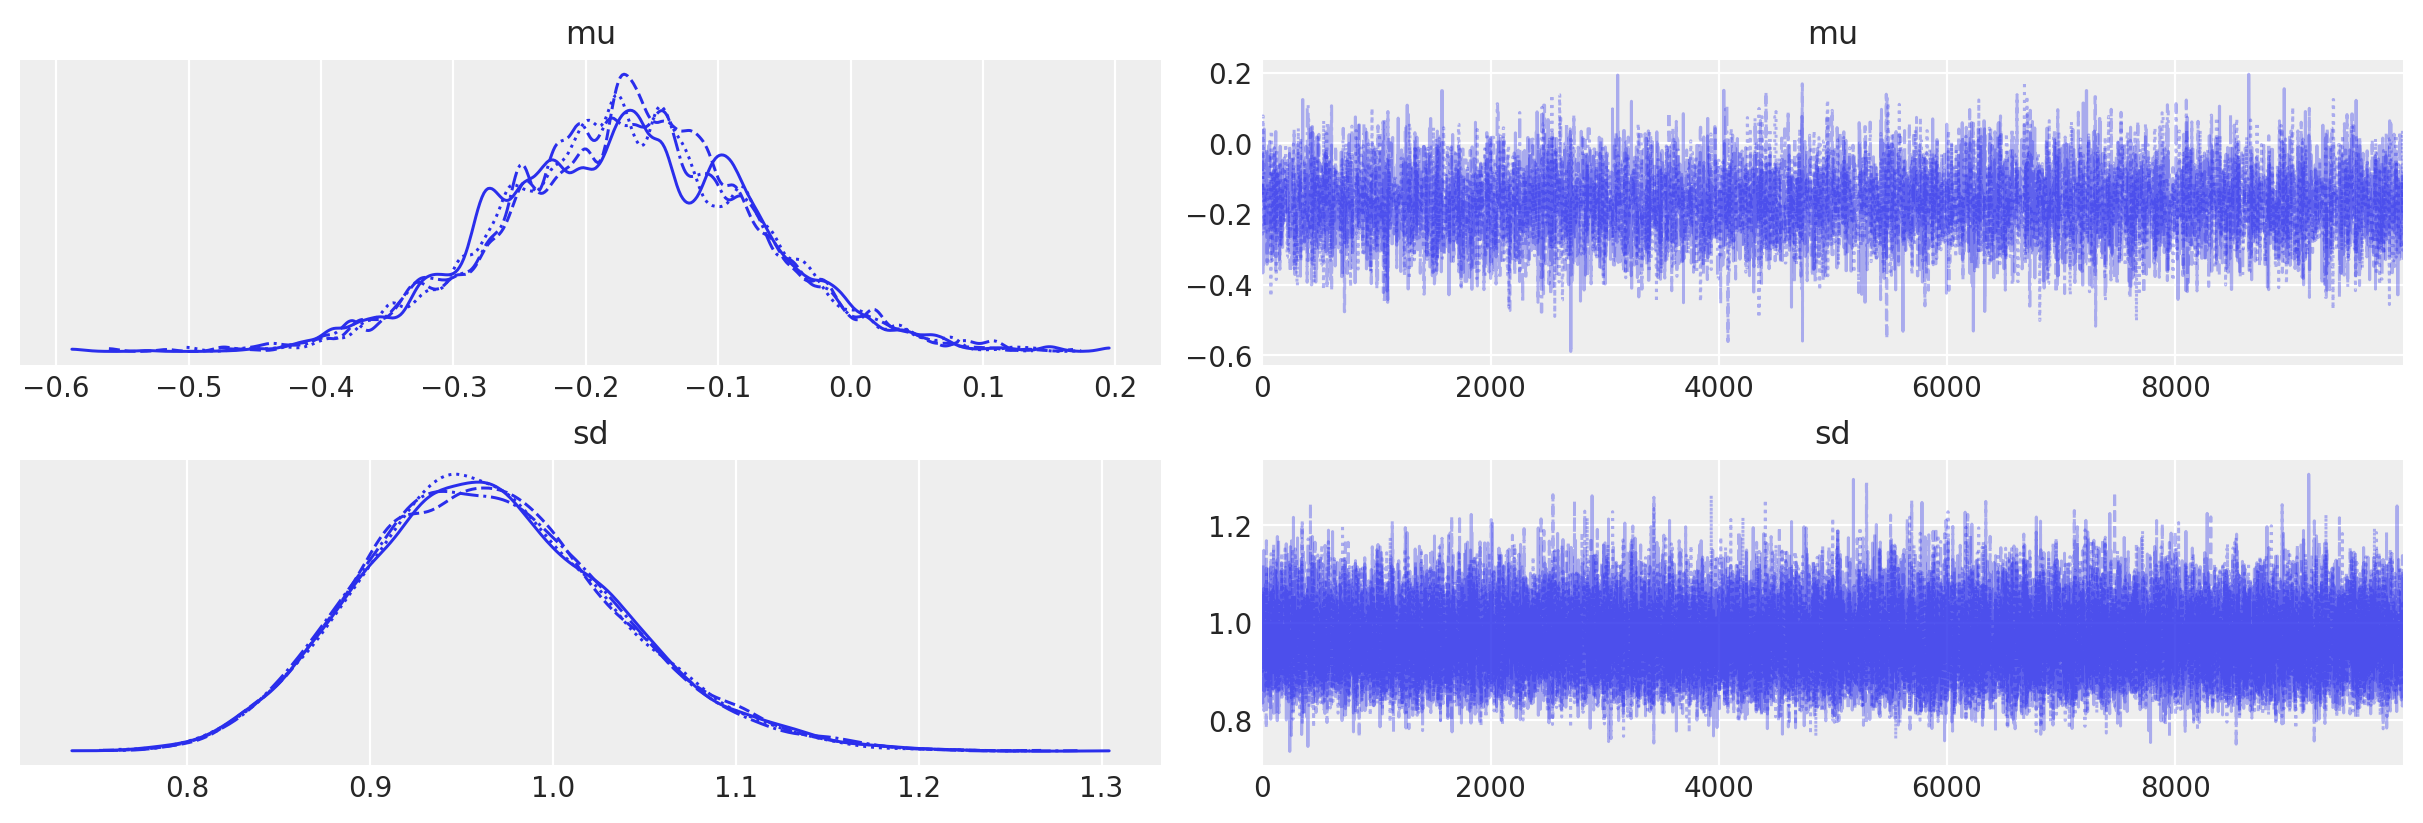

In [37]:
az.plot_trace(idata)

In [38]:
az.summary(idata) # Gelman-Rubin statistic

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.170,0.095,-0.346,0.015,0.001,0.001,6011.0,5891.0,1.0
sd,0.965,0.069,0.837,1.097,0.000,0.000,35527.0,27706.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

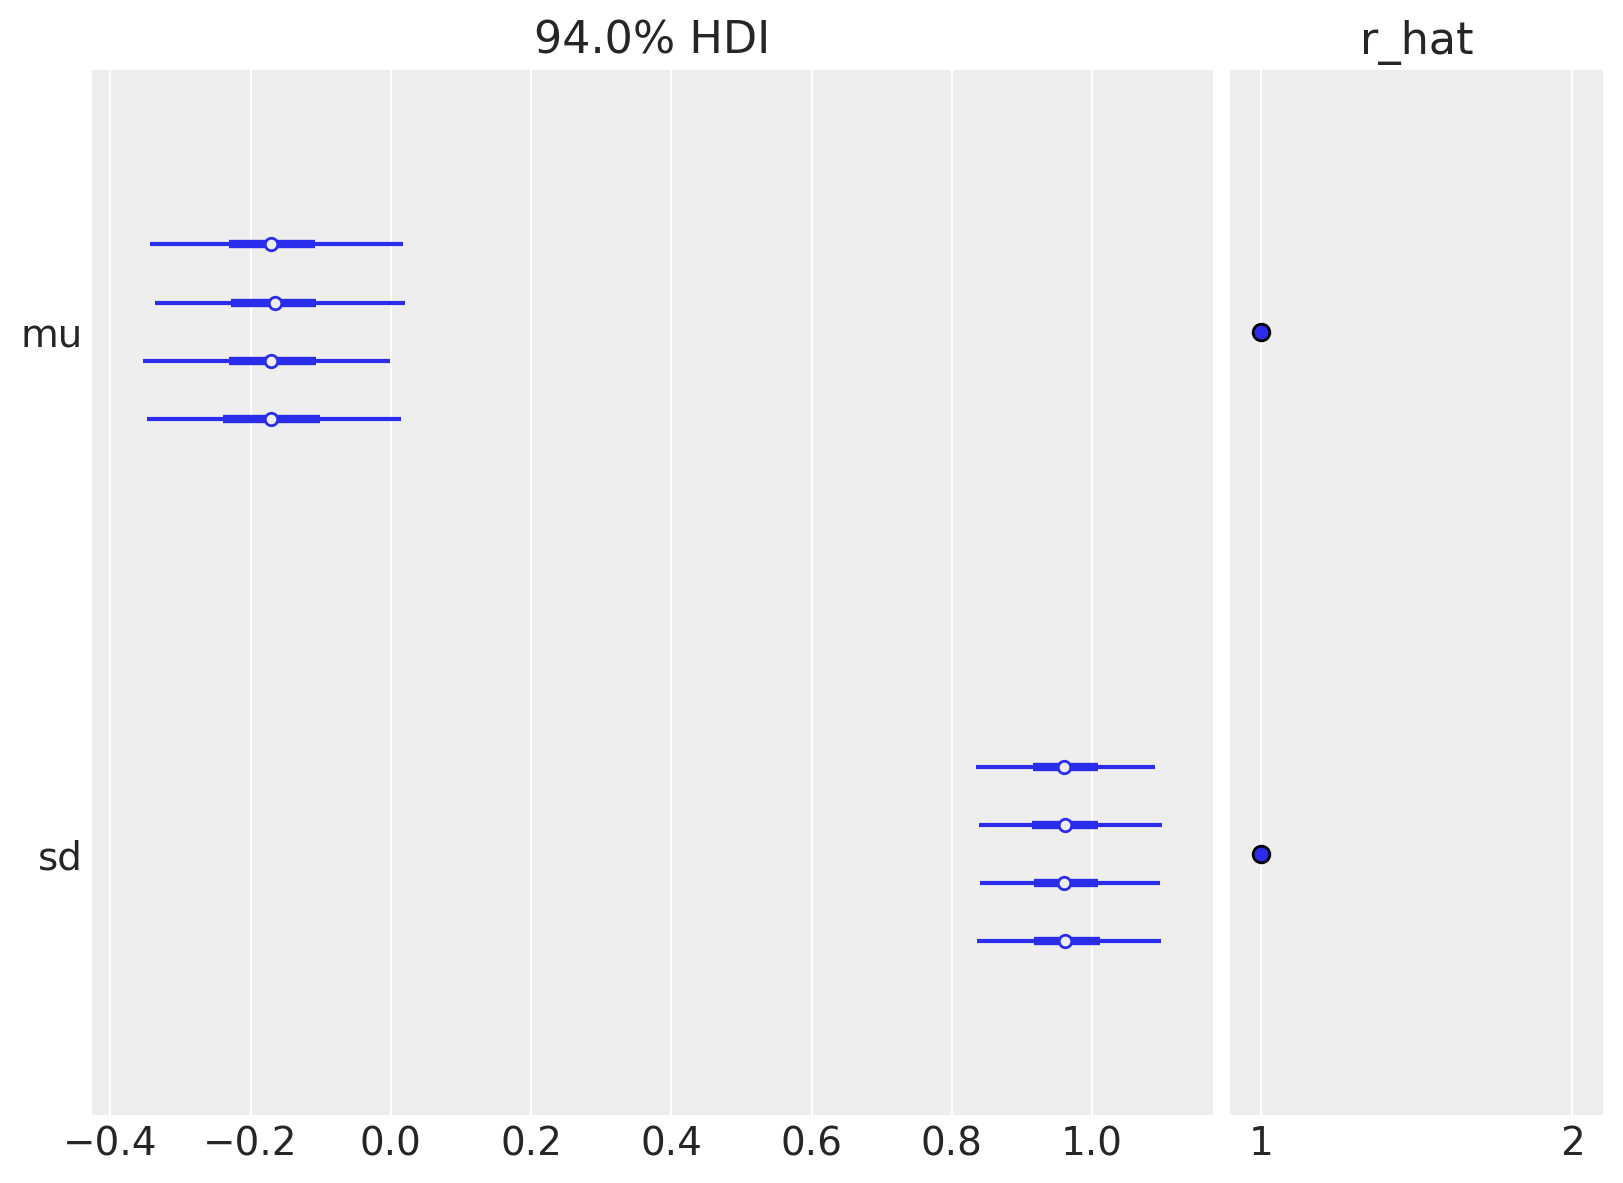

In [39]:
az.plot_forest(idata, r_hat=True) # forest plot

* [Doing Bayesian Data Analysis](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial-dp-0124058884/dp/0124058884/ref=dp_ob_title_bk)에 나온 내용에 영감을 받아 posterior plot을 그리면 다음과 같다. 


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sd'}>], dtype=object)

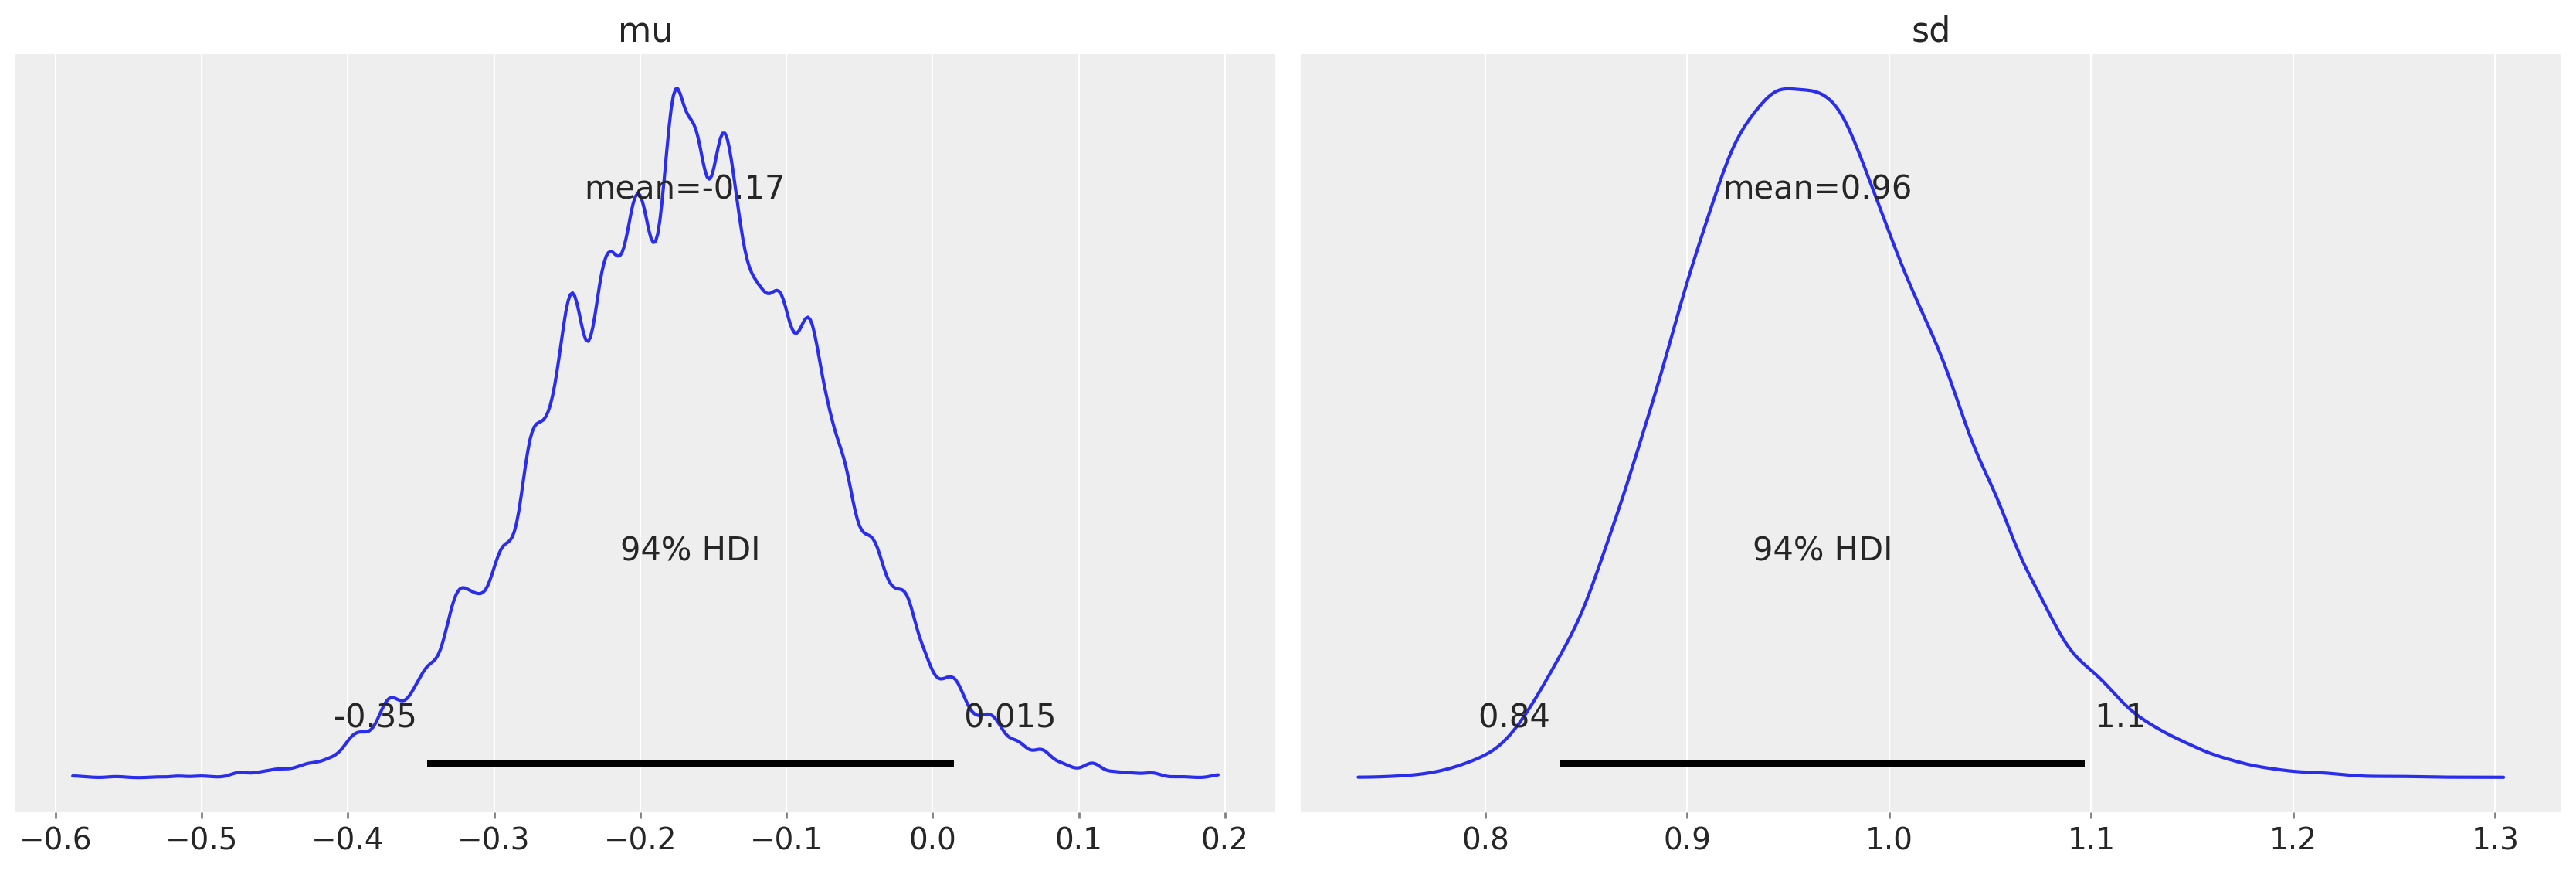

In [40]:
az.plot_posterior(idata)

* 다차원 모델에서는 이렇게 파라미터를 보기 힘들다. NUTS를 사용하면 우리는 에너지 플롯을 이용해 수렴문제에 접근할 수 있다. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


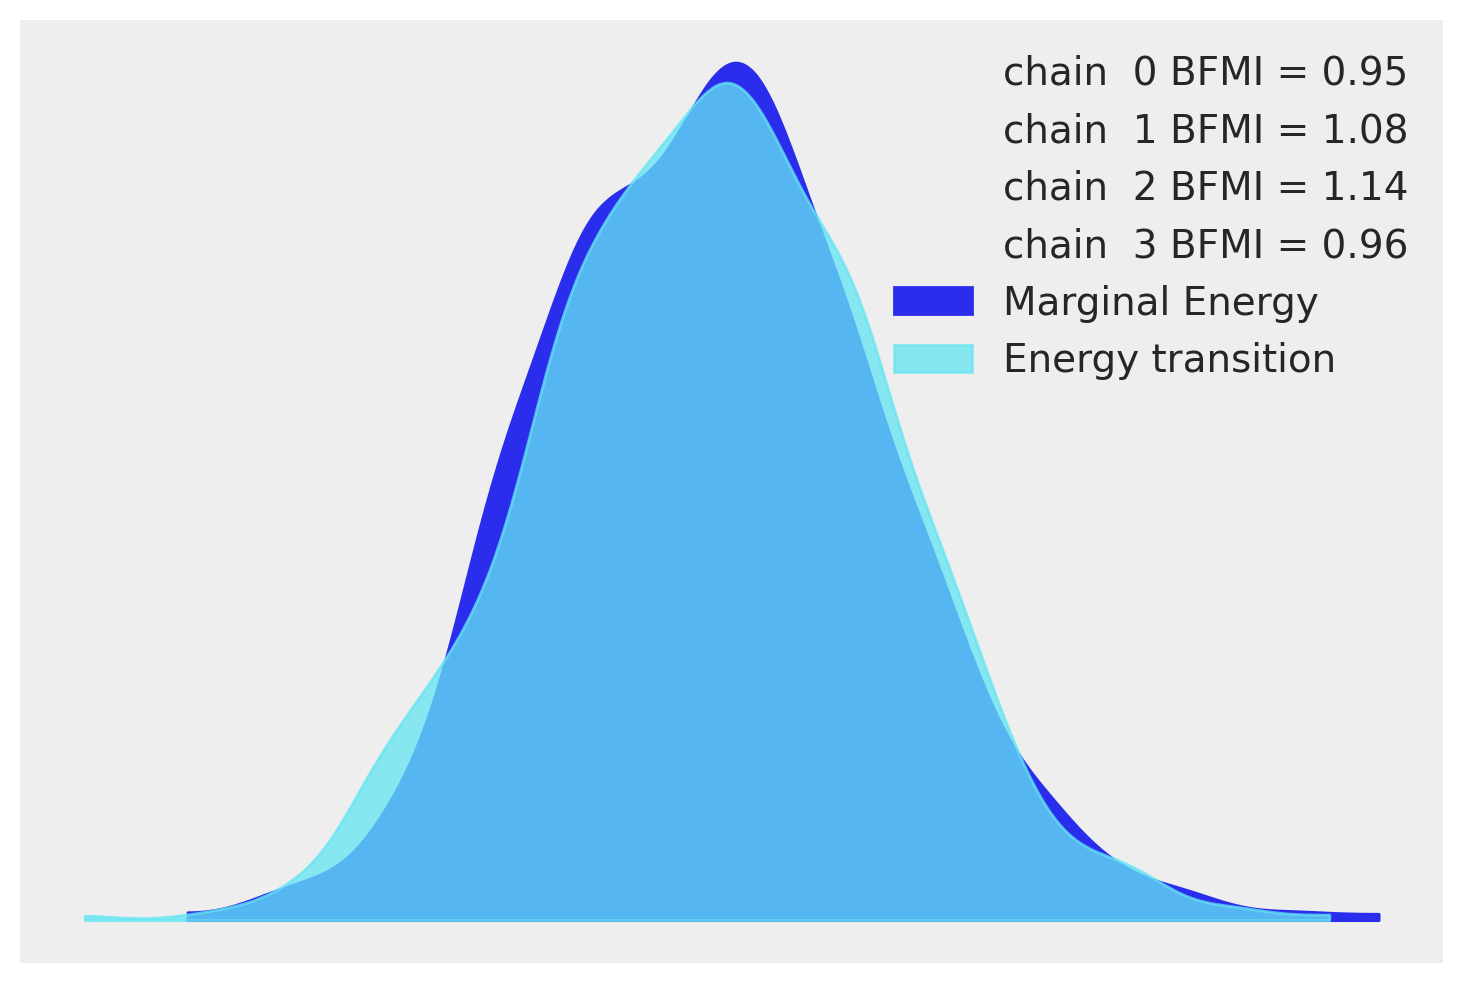

In [41]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1, shape=100)
    idata = pm.sample(cores=4, return_inferencedata=True)

az.plot_energy(idata)

* 위의 통계치나 plot들에 대해 더 자세히 알고 싶다면, 다음 tutorial들을 참고하라.
* [Sampler statistics](https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/sampler-stats.html)
* [Diagnosing Biased Inference with Divergences](https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html)

### 3.3 Variational inference

* PyMC3는 다양한 variational inference 기법을 지원한다. 이런 방법은 빠를때도 있지만, 정확도가 떨어져 편향된 추론으로 이끌기도 한다. 
* pymc.fit()을 이용하면 된다.

In [42]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    approx = pm.fit()

Finished [100%]: Average Loss = 145.77


* pm.fit()으로 반환된 Approximation은 다양한 걸 할 수 있다. 추정된 posterior에서 샘플을 추출할수도 있어 일반적인 샘플링하듯 다룰 수 있다. 

In [43]:
approx.sample(500)

<MultiTrace: 1 chains, 500 iterations, 3 variables>

* variational 서브모듈은 variational inference를 객체지향적 디자인에 맞도록 유연성을 제공한다. 예를 들어 full-rank ADVI는 full covariance 매트릭스를 추정한다.

In [44]:
mu = pm.floatX([0.0, 0.0])
cov = pm.floatX([[1, 0.5], [0.5, 1.0]])
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    approx = pm.fit(method="fullrank_advi")

Finished [100%]: Average Loss = 0.0065707


In [45]:
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    approx = pm.FullRankADVI().fit() # equivalent expression using the object-oriented interface


Finished [100%]: Average Loss = 0.011343


<AxesSubplot:>

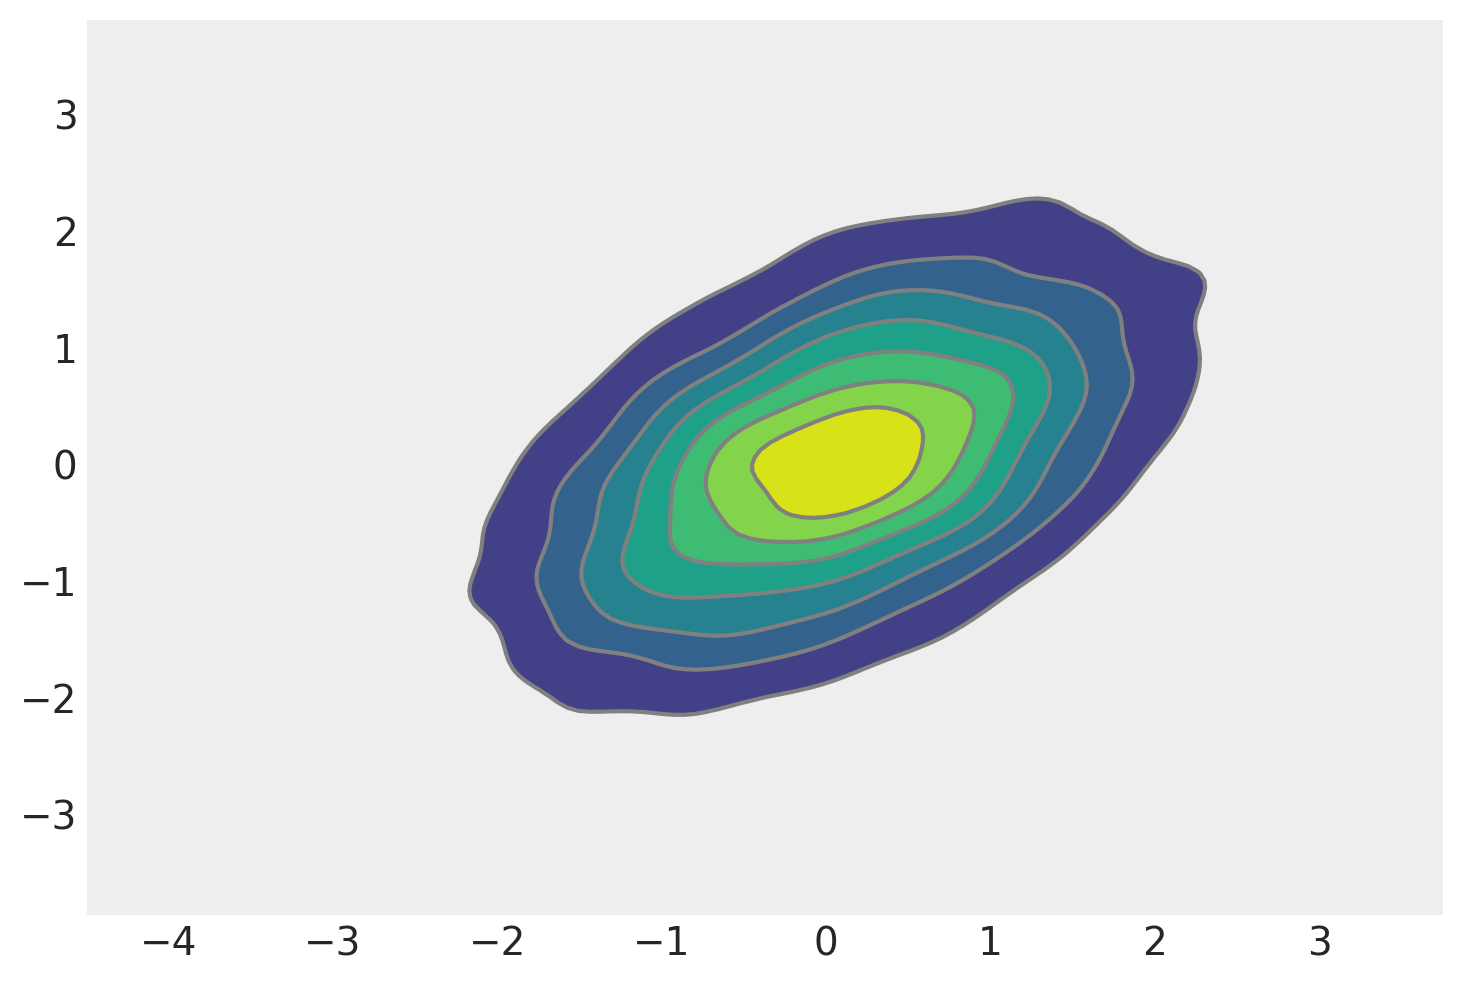

In [46]:
plt.figure()
trace = approx.sample(10000)
az.plot_kde(trace["x"][:, 0], trace["x"][:, 1])

* Stein Variational Gradient Descent (SVGD)는 posterior를 추정하기 위해 입자(particle)을 이용한다.

In [47]:
w = pm.floatX([0.2, 0.8])
mu = pm.floatX([-0.3, 0.5])
sd = pm.floatX([0.1, 0.1])
with pm.Model() as model:
    pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.0))

<AxesSubplot:>

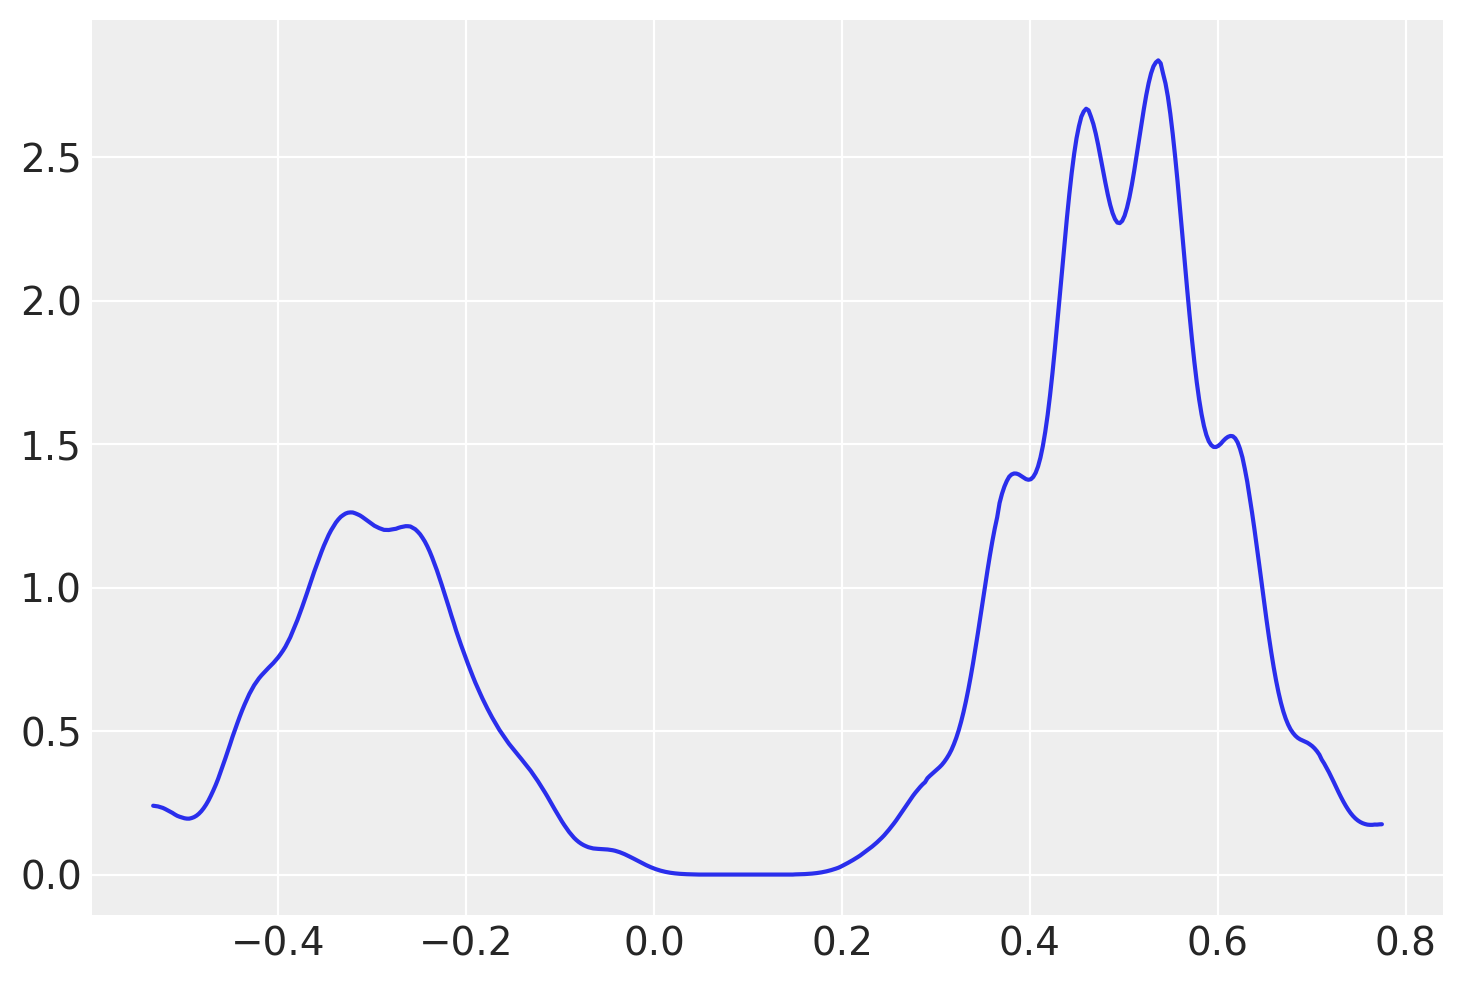

In [48]:
plt.figure()
trace = approx.sample(10000)
az.plot_dist(trace["x"])

* Variational inference에 대한 [다양한 예제](https://docs.pymc.io/en/v3/nb_examples/index.html)가 PyMC3 공식 홈피에 있다.

## 4. Posterior Predictive Sampling


In [49]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [50]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)
# add posterior predictive to the InferenceData
az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

/home/hyunsu/anaconda3/envs/bayes/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


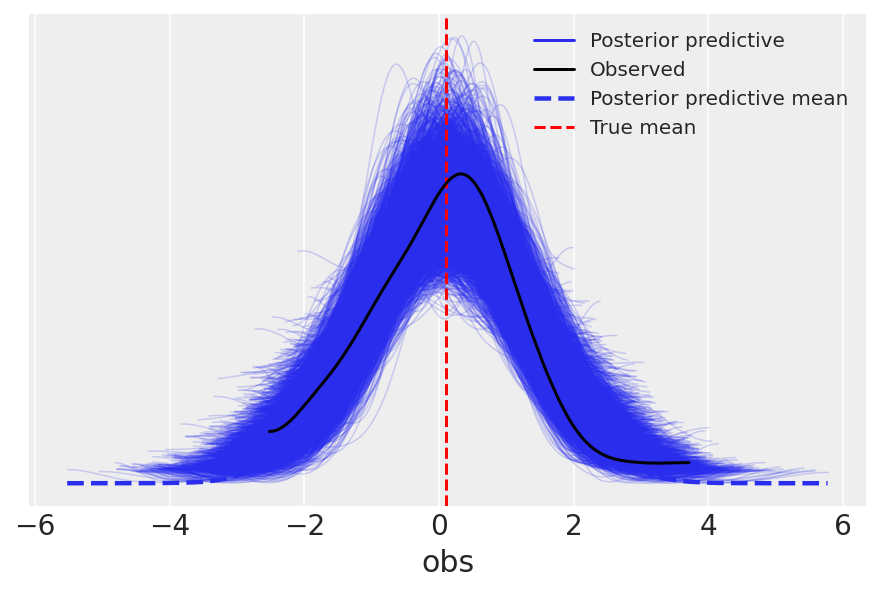

In [56]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10)

### 4.1 Predicting on hold-out data

* 많은 경우 unseen data를 예측하고 싶을 것이다. 확률적 기계학습과 베이지언 딥러닝에서 중요하다. pm.Data container를 통해 PyMC3에서 지원한다. 이건 theano.shared의 wrapper다. 다른 np.array나 tensor처럼 취급될 수 있다. symbolic expression으로 다룰 때 유용하다.

In [57]:
x = np.random.randn(100)
y = x > 0

with pm.Model() as model:
    # create shared variables that can be changed later on
    x_shared = pm.Data("x_obs", x)
    y_shared = pm.Data("y_obs", y)

    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli("obs", p=logistic, observed=y_shared)
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


* 이제 unseen data를 예측하려 한다고 해보자. 이걸 위해 우리는 x_shared와 y_shared를 변경해야 한다. 이론적으로 우리가 예측하려는 y_shared를 설정할 필요는 없지만, x_shared와 shape이 맞아야 한다. 

In [58]:
with model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # use dummy values with the same shape:
            "y_obs": [0, 0, 0],
        }
    )

    post_pred = pm.sample_posterior_predictive(idata.posterior)

In [59]:
post_pred["obs"].mean(axis=0)

array([0.02175, 0.4895 , 0.977  ])